# A/B Testing

Let's say we made a minor modification to a website, or to an ad. For example, we might have an email campaign with two slightly different headings

|Variation | Text | Clicks | Impressions |
|---|:---:|---|---|
|A|	"Great savings inside" |127 | 5734 |
|B|	"Save up to 10% on your next order" |174	| 5851 |

Here "Impression" means someone saw the variation, and "click" means they actually opened it and read it. 

How effective were the two campaigns? For the two campaigns, we have

In [2]:
from collections import namedtuple

variation = namedtuple('variation', 'clicks impressions')

A = variation(clicks=127, impressions=5734)
B = variation(clicks=174, impressions=5851)

for v in [A,B]:
    rate = v.clicks/v.impressions
    print(rate)

0.022148587373561214
0.029738506238249873


It seems that campaign B ("Save up to 10% on your next order") was more effective at getting people to open the ad. Is this difference significant? To answer this, we can ask the following question:

* If the ads were equally effective, what is the chance that variation B would beat variation A by this much?

There are three different approaches we can take to this:
1. Direct simulation
2. A normal distribution test
3. A $\chi^2$ (chi-square) analysis

We will investigate the first and second approaches here.

## Significance by simulation (post-hoc)

1. Assume that both variations perform the same. Find the common conversion rate p
2. Calculate if 5734 people come to variation A, what fraction $p_A$ of them convert (random sample with probability p)
3. Calculate if 5851 people come to variation B, what fraction $p_B$ of them convert (random sample with probability p)
4. Calculate the difference $|p_B - p_A|$. 
5. Repeat the steps 2 -- 4 a large number of times. Count the fraction of times that $|p_B - p_A|$ is bigger than the observed value (0.02974-0.02215 = 0.00759)

In [3]:
import numpy as np

def draw_clicks_from_n_samples(impressions, prob_click, num_trials):
    return np.random.binomial(impressions,prob_click,size=(num_trials,))

def draw_p_sample_from_n_samples(impressions, prob_click, num_trials):
    return draw_clicks_from_n_samples(impressions,prob_click,num_trials)/impressions

num_trials = 10000
imp_A, imp_B = 5734, 5851
click_A, click_B = 127, 174

difference_in_rate = abs(click_A/imp_A - click_B/imp_B)

# What was the total conversion rate?
p = (click_A + click_B)/(imp_A + imp_B)

p_A_array = draw_p_sample_from_n_samples(imp_A, p, num_trials)
p_B_array = draw_p_sample_from_n_samples(imp_B, p, num_trials)

result_by_chance = (abs(p_B_array - p_A_array) > difference_in_rate)
sum(result_by_chance)/len(result_by_chance)

0.0101

In [4]:
def get_p_value_from_simulation(num_trials, variation_A, variation_B):
    imp_A, imp_B = variation_A.impressions, variation_B.impressions
    click_A, click_B = variation_A.clicks, variation_B.clicks
    
    p = (click_A + click_B)/(imp_A + imp_B)
    
    difference_in_rate = abs(click_A/imp_A - click_B/imp_B)
    
    p_A_array = draw_p_sample_from_n_samples(imp_A, p, num_trials)
    p_B_array = draw_p_sample_from_n_samples(imp_B, p, num_trials)
    result_by_chance = (abs(p_B_array - p_A_array) > difference_in_rate)
    return sum(result_by_chance)/len(result_by_chance)

In [6]:
get_p_value_from_simulation(10000, A, B)

0.0112

## Analysis by normal distribution (post-hoc)

Some notation:
- the _sample proportion_ $p_A$ is what we measure when we do the experiment
- the _population proportion_ $\pi_A$ is the actual value of the mean (if we did an infinite number of samples)
- If we have a sample size of $N$ (and $N \gg 30$, as well as a couple of other technical points) then the proportion $p_A$ should be normally distributed with a mean of $\pi_A$ and a variance of $\pi_A(1-\pi_A)/N

We are looking for the difference between $\pi_A$ and $\pi_B$. The null hypothesis is that these rates are the _same_. The variance in the difference of the rates is 
$$\sigma^2_{\text{diff}} = \frac{\pi_A(1-\pi_A)}{N_A} + \frac{\pi_B(1-\pi_B)}{N_B}$$

We want to how likely it is that $|p_A - p_B|$ is bigger than the value actually found in the experiment, if we assume $\pi_A = \pi_B$. Our $z$-score is
$$|z| = \frac{|p_A - p_B|}{\sqrt{\frac{p_A(1-p_A)}{N_A} + \frac{p_B(1-p_B)}{N_B}}}$$

We can use the CDF to find the probability that we get a $z$ score greater in magnitude than the one found. 
![normal distribution](image/normal.png)
We want to find the total shaded area. The area to the left of $b$ is 
$$P(z > b) = 1 - cdf(b)$$
Since the area less than $-b$ is the same (symmetry of the normal distribution with mean 0), we know the $P$ value is

\begin{equation*}
\text{p-value} = P(|z| > b) = P(z<-b) + P(z>b) = 2 P(z > b) = 2(1 - cdf(b))
\end{equation*}

In [8]:
from scipy.stats import norm

p_A, p_B = A.clicks/A.impressions, B.clicks/B.impressions
p = (A.clicks + B.clicks)/(A.impressions + B.impressions)
variance = p*(1-p)/A.impressions + p*(1-p)/B.impressions # null hypothesis - only one p

abs_z = abs(p_A - p_B)/np.sqrt(variance)

p_value = 2*(1-norm.cdf(abs_z))
p_value

0.010242813991217181

Let's write a function to encapsulate this

In [9]:
def get_p_value_analytic(variationA, variationB):
    p_A, p_B = (variationA.clicks/variationA.impressions, 
                variationB.clicks/variationB.impressions)
    p = (A.clicks + B.clicks)/(A.impressions + B.impressions)
    variance = p*(1-p)/variationA.impressions + p*(1-p)/variationB.impressions
    
    abs_z = abs(p_A - p_B)/np.sqrt(variance)
    
    p_value = 2*(1-norm.cdf(abs_z))
    return p_value

In [10]:
get_p_value_analytic(A,B)

0.010242813991217181

## Post-hoc vs apriori

The tests described so far are how we find the $p$-value _after the experiment has concluded_. The $p$-value tells us whether the result is statistically significantly different from chance (specifically, it tells us the chance of a result this large happening if we assume there is no difference in the variations). 

There are lots of misconceptions about $p$-values. This is a good time to address one of them: the idea that the lower the $p$-value, the better one variation is than the other. This is _mostly false_. If two variations are different (and let's face it, there is always __some__ difference), then for a large enough sample size $N$, you can find a tiny $p$-value. At a **fixed** sample size $N$, it is true that bigger differences in proportion lead to smaller $p$-values (which is the origin of this misconception).

Why do we care about this? When designing an A/B test, one of the questions we should answer before collecting any data is
> We have two variations (A and B). Before the experiment, we want to know how long we should run the experiment before drawing a conclusion. How long should that be?

i.e. we don't know the size of the experiment $N$; that is what we are trying to determine. The longer we run the experiment, the more we are "missing out" on the opportunity costs of employing the "better" variation. We know we can detect the difference if we run the experiment long enough, but we should know "is it worth it?"

To answer this, we need to know
- what difference in proportion is worth measuring?
- the expected rate of visitors at our site
- the period of cycles within our buisness (often weekly or monthly)

Then we can determine how long we should run the experiment in order to detect the difference.

### How to do it: statistical power

The $p$-value asks the question: if there is no difference, what is the probability that our experiment finds a result at least as big as the one we found? If we declare a cutoff on the $p$-value of 5%, we are claiming that we are willing to make a __Type I error__ 5% of the time. We calculate $p$-values after the experiment. The cutoff for the $p$-value is often denoted $\alpha$.

The _power_ $\beta$ asks the question: if there __is__ a difference of size $\Delta p$, what is the propability that our experiment (with the cutoff) finds it? In order to answer this question, we have to give the full experimental procedure. It is related to the chance of a __Type II error__, but isn't the same as it.

Let's take an experiment with $\alpha = 5\%$ (i.e. we claim that we don't have evidence for the two variations being different if $p > 0.05$, and if $p<0.05$ we claim one a winner but acknowledge we would get this result 5% of the time if the variations are the same). Using knowledge of the normal distribution, the procedure is:
1. Calculate the $z$-score under the null hypothesis:
\begin{equation*}
|z_0| = \frac{|p_A - p_B|}{\sqrt{\frac{p(1-p)}{N_A} + \frac{p(1-p)}{N_b}}}
\end{equation*}
Here $p$ is the pooled probability.
2. If $|z_0| < 1.96$, then we claim no winner
3. If $|z_0| \geq 1.96$, we declare the winner to be the higher probability.

#### The math background

Let's analyize this same experiment under the hypothesis that there is a difference $\Delta p$, i.e. $\pi_B - \pi_A = \Delta\pi$. We want to know, __assuming there is a difference of size $\Delta \pi$__, what is the chance that the experiment above gets $|z_0| > 1.96$? 

If $z_0= 1.96$, and assuming $p_B$ is the variation that did better, this tells us 
$$p_B - p_A = 1.96 \sqrt{\frac{p(1-p)}{N_A} + \frac{p(1-p)}{N_B}}$$
This is the "critical value" -- differences bigger than this will lead to acceptance, while difference smaller than this lead to rejection. What is the $z$ score of this difference under the hypothesis that there is a difference?
\begin{equation*}
|z_2| = \frac{(\pi_B - \pi_A) - (p_B - p_A)}{\sigma_{\Delta p}} = \frac{\Delta \pi - 1.96 \sqrt{\frac{p(1-p)}{N_A} + \frac{p(1-p)}{N_B}}}{\sqrt{\frac{p_A(1-p_A)}{N_A} + \frac{p_B(1-p_B)}{N_B}}}
\end{equation*}
We can simplify this a lot if we assume that $N_A = N_B$:
\begin{equation*}
|z_2| =  \frac{\Delta \pi - 1.96 \sqrt{\frac{2p(1-p)}{N}}}{\sqrt{\frac{p_A(1-p_A)+p_B(1-p_B)}{N}}} = \frac{\Delta \pi \sqrt{N} - 1.96 \sqrt{2p(1-p)}}{\sqrt{p_A(1-p_A)+p_B(1-p_B)}}
\end{equation*}
We now solve for $N$, the number needed for each variation:

\begin{equation*}
N = \frac{(|z_2|\sqrt{p_A(1-p_A) + p_B(1-p_B)} + 1.96\sqrt{2p(1-p)})^2}{(\Delta \pi)^2}
\end{equation*}

#### The procedure

So what does all that mean? Let's walk through an example. Let's say that we have an email campaign with headline "Great Savings inside" that gets about 2% click-throughs. We want to run an experiment with an alternative heading ("Save up to 10% on your next order") at a confidence level of $\alpha = 5\%$. We want to be able to detect differences of $1\%$ at least $80\%$ of the time.

Our question: How many emails $N$ of each variation do we need to run the experiment?

Our answer:
1. Figure out $z_2$, so that $P(z > z_2) = 0.8$. In this case, we use `z2 = norm.ppf(1-0.8) = -0.8416`, meaning that you have a z-score higher than $-0.8416$ in 80% of trials.
2. Get parameters: 
  We have $p_A = 2\%$ (historical), and $p_B = 3\%$ (detect a 1\% improvement). We have $\Delta \pi = 1\%$ as well. The pooled conversion rate is $p = (p_A + p_B)/2 = 2.5\%$. It is a simple average because we are assuming equal numbers of people to our variations.
3. Do the calcuation, in the cell below

In [13]:
alpha, beta = 0.05, 0.8
p_A=0.02
DeltaPi = 0.01

p_B = p_A + DeltaPi
p = 0.5*(p_A + p_B)

z2 = abs(norm.ppf(1-beta))
z_crit = norm.ppf(1-alpha/2)  # this is 1.96

root_N = (z2*np.sqrt(p_A*(1-p_A) + p_B*(1-p_B)) + z_crit*np.sqrt(2*p*(1-p))) / DeltaPi
N = root_N**2
N

3825.1497221026216

i.e. you should plan on having 3826 people in variationA and 3826 people in variationB. If we have fewer than this number of people then we probably will conclude that there is no difference. Note that larger differences (larger $\Delta\pi$) are easier to detect than smaller differences

In [14]:
def power_function(p_A_base, DeltaPi, alpha=0.05, beta=0.8):
    p_B = p_A + DeltaPi
    p = 0.5*(p_A_base + p_B)
    
    z2 = abs(norm.ppf(1-beta))
    z_crit = norm.ppf(1-alpha/2)
    root_N = (z2*np.sqrt(p_A*(1-p_A) + p_B*(1-p_B)) + z_crit*np.sqrt(2*p*(1-p)))/ DeltaPi
    return int(np.ceil(root_N**2))

In [15]:
# Same idea as hypothetical above, wrapped in a function
power_function(0.02, 0.01)

3826

#### Why $(1-\beta)$ is not (quite) the Type II error

You can see a lot of statements that if $\beta$ is the statistical power, then $1-\beta$ is the type II error rate. This isn't quite right. The way we defined it, $1-\beta$ is the probability of making a type II error _if we know the difference in proportion is exactly our threshold of caring_. If it is likely that the difference in proportion is higher than our threshold of caring, then $1-\beta$ is an overestimate of the type II error (because the difference is easier to find than we cared about). Similiarly, if the difference is smaller than expected, $1-\beta$ is an underestimate of the type II error.

The actual probability of a type II error occuring depends on the _prior_ distribution of probability differences. We haven't specified a prior here, so we cannot calculate the type II error.

### Practical issues with A/B testing

Let's continue our example. If we have a "bank" of customers, we could fire off 3826 emails of variation A, 3826 emails of variation B, and then if B performed better, we could email the rest of our customers variation B. If A did better, or there was no clear winner, we would fall back to the default of A.

Let's say that we were interested in only targeting new signups, and that our site had 3000 people join a week. Then how long would we run our test?

A naive estimate would be that we need a total of 3826 * 2 = 7652 people. We have 3000 / 7 = 428 people per day. So maybe we should run the experiment for 7652 / 428 = 17 days?

This is fine, provided the type of people that visit our site on Monday are the same as the people that visit on Saturday. Often, websites have different volumes of traffic depending on day of the week. Employed people have different representation during the week than after it (over- or under-representation depends on the site: EW.com has a different profile than LinkedIn)

If there is a weekly cycle, you are better to round up to the nearest whole week. In this case: 7652 / 3000 = 2.55, so I would run for three weeks before drawing a conclusion. If I was looking at high cost purchases, I might see monthly patterns in my sales (as most people are paid monthly). If I did see significant monthly variation, I would push to extend the experiment to run for a month.

You should also consider (at design time) splitting your customers into clusters. Just because variationA outperforms variationB over the entire population, you can find that variationB outperfoms variationA on some subset (e.g. people on the west coast, people that log on after 5 pm, et cetra). You can choose to show different variations for different clusters. If you do this, you should know that the power calculations for sample size are the number of people that need to see each variation _per cluster_, rather than overall.

We have phrased A/B testing in terms of clicking through an email. Generally there are two types of A/B tests I have seen:
1. Engagement: do people who see variation A use the site more than people who see variation B? We are interested in optimizing the return rate.
2. Call-to-action: Each view of a variation asks a user to do something (e.g. open the email). We are interested in optimizing the success rate, which is between 0 and 1.

Our methods have all been based around "call-to-action" (see the email, then open it). Sometimes it is less clear cut, especially for "Engagement" campaigns. If you change the Duolingo Owl graphics to see if you can entice people back to learn a language more, are you going to count the number of visits that user has to the site for the next day as correlated with the campaign? The next week? The next month? Determining the answer to these questions is often a mix of looking at historical records of your users, and experimentation.

Another common use-case is looking at user-flow through a sign-up process. When do the users leave? If you show them a different process, do more of them sign up? Are you optimizing for total number of signups, or are you interested in only particular demographics. To avoid multiple testing, you should plan you experiment (including the metrics) **before** running the experiment.

A case that has less to do with web-development: you can also A/B test your pricing and discount structures. Uber and Lyft do this when experimenting with surge pricing and incentives for drivers. Here you have to be particularly careful, because the experiments can interfere with each other. A great example of this is on Lyft's blog:

https://eng.lyft.com/experimentation-in-a-ridesharing-marketplace-b39db027a66e

The experiment here was to compare a passengers that didn't get charged a surge with those that do. In an experiment where there is only one car nearby to pickup, the person with the cheaper fare will be more likely to request a ride than the person with the more expensive fare. This is what Lyft want to measure. But the effect is compounded by "blocking": whoever takes the car first stops the other person from taking the same car. In a naive A/B test or simulation where you randomly assign people to the variations, the people with the discount are expected to take $3\times$ more rides compared to those that don't. If you design the experiment differently to eliminate "blocking" (e.g. discount surges for everyone at randomly selected times) the actual effect is closer to a $1.33$ multiplier -- a huge difference!


You should aslo communicate to the devs on your team that, where possible, the same user should see the same variation each time. If Amazon is running an A/B test with green "buy" buttons, they should make sure that I see a green "buy" button until the experiment is over. Randomly seeing different elements can make people skeptical about using a site.



## What not to do: early stopping

It might be tempting to skip all the power calculations and just work "until you have reached a p-value of 0.05" and then take the winner.

**This is bad**

The p-value assumes that you do the check _once_. As a rough guide, if you do $N$ checks, if there is no difference, each time you have a probability of $\alpha$ of (falsely) claiming a winner. The probability of (correctly) claiming at no one winners in N trials is roughly
$$(1-\alpha)^N$$
I say roughly, because the trails are not independent of each other. But assuming this formula is correct, here is a table showing the effect of multiple evaluations for $\alpha = 0.05$

| Number of evaluations | Prob of correctly saying no difference | Prob of concluding difference |
|---:|---:|---:|
| 1 | 0.95 | 0.05 |
| 2 | 0.90 | 0.10 |
| 5 | 0.77 | 0.23 |
|10 | 0.59 | 0.41 |

Let's run a simulation, where at the end of the day we do a significance test until we reach the end. We will assume 200 visits a day (100 for each variation).

In [16]:
def do_day(pA, pB, num_visits = 100):
    cA = draw_clicks_from_n_samples(num_visits, pA, 1)[0]
    cB = draw_clicks_from_n_samples(num_visits, pB, 1)[0]
    return (variation(clicks=cA, impressions=num_visits), 
            variation(clicks=cB, impressions=num_visits))


In [17]:
def cumulative_variation(var_before, var_new):
    return variation(clicks=var_before.clicks + var_new.clicks,
                     impressions = var_before.impressions + var_new.impressions)

def get_prop_from_variation(var):
    return var.clicks / var.impressions

def run_test_with_peeking(n_days, pA, pB, alpha = 0.05):
    cumulative_var_A = variation(clicks=0, impressions=0)
    cumulative_var_B = variation(clicks=0, impressions=0)
    for day in range(n_days):
        varA, varB = do_day(pA, pB)
        cumulative_var_A = cumulative_variation(cumulative_var_A, varA)
        cumulative_var_B = cumulative_variation(cumulative_var_B, varB)
        p_value = get_p_value_analytic(cumulative_var_A, cumulative_var_B)
        if p_value < alpha:
            if get_prop_from_variation(cumulative_var_A) > get_prop_from_variation(cumulative_var_B):
                winner = 'A'
            else:
                winner = 'B'
            return {
                'day': day,
                'winner': winner,
                'p': p_value
            }
    return {
        'day': day,
        'winner': None,
        'p': p_value
    }

In [21]:
# run a single time with pA = pB = 5% over 30 days
run_test_with_peeking(30, 0.05,0.05)

{'day': 9, 'winner': 'B', 'p': 0.04908410065122215}

In [22]:
# Let's simulate 1000 experiments. How often are they called?
all_exp = [run_test_with_peeking(30, 0.05, 0.05) for _ in range(1000)]

In [29]:
# How many had the correct answer, None, as the winner?
num_type_1_errors = len([e for e in all_exp if e['winner'] is not None])
frac_type_1_errors = num_type_1_errors/len(all_exp)
print("With peeking and alpha=0.05, we had a type 1 error rate of {}".format(frac_type_1_errors))

With peeking and alpha=0.05, we had a type 1 error rate of 0.623


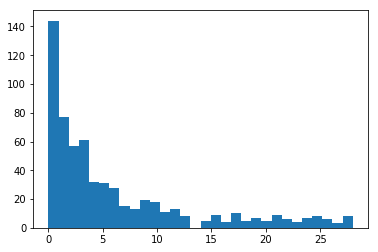

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

# How long did it take to reach the incorrect conclusion?
num_days = [e['day'] for e in all_exp if e['winner'] is not None]
plt.hist(num_days, bins=30);

# Alternative to early stopping: multi-armed bandit

The multi-armed bandit approach to the same problem is modelling off the following: each variation is like a slot machine. You have a certain number of customers to "spend", and you might get a reward if they win. You have to decide how to "spend your customers" (i.e. how to split them amongst the different variations)

The basic idea is simple:
1. Play a "few" rounds, and see how well each variation does (exploratory phase)
2. When a user arrives, assign her randomly to a variation. Variations that are doing better (i.e. have higher conversion rates) have a higher probability of being picked.  Record what the new user does (success vs fail). Update the probabilities to reflect current conversion rates. (exploitation phase).

The idea is that variations that do well will be selected more often, and variations that do poorly will "die out". There are a couple of different ways of implementing step 2 (mapping from success rates to chance of picking a variation).

Two common methods are __epsilon greedy__ and __thompson sampling__

## Epsilon greedy (technically epsilon-first greedy)

Basic setup:

You will need to pick $N$ (the number of users you use to evaluate the variations initially), and $\epsilon$ (the probability of exploring).

1. Use the first N users (you choose N) to determine the success rate of each variation
2. For each user, pick a number between 0 and 1. If the number is less than $\epsilon$, randomly choose a variation. Otherwise, just send the user to the current best variation.

In [18]:
def isSuccess(prob):
    return np.random.rand() < prob

def epsilon_greedy_sim(N0, epsilon, actual_probs, num_trials):
    """
    N0: integer, number of users to send to each variation
    epsilon: float between 0 and 1. Probability of exploring new variation
    actual_probs: a list of probabilities of success for each variation
    num_trials: num of users total to use after the initialization
    
    returns a list of success rates found by the simulation
    """
    current = [variation(clicks=sum([isSuccess(p) for _ in range(N0)]), impressions=N0)
                     for p in actual_probs]
    for _ in range(num_trials):
        if isSuccess(epsilon):
            # randomly pick a variation
            var_to_do = np.random.randint(0,len(actual_probs) - 1)
        else:
            var_to_do = np.argmax(np.array([get_prop_from_variation(v) for v in current]))
        current[var_to_do] = cumulative_variation(current[var_to_do], 
                                                  variation(clicks = isSuccess(actual_probs[var_to_do]), impressions=1))
        
    return current

In [19]:
# here is an example using 3 variations with 4% conversion rate, 3% and 2% respectively
np.random.seed(42)
epsilon_greedy_sim(100, 0.1, [0.04, 0.03,0.02], 10000)

[variation(clicks=417, impressions=9577),
 variation(clicks=14, impressions=623),
 variation(clicks=3, impressions=100)]

Note this identified mostly variation A, which is what we want. If the variations are close, a sub-par variation can take the lead early, and then keeps it:

In [20]:
#np.random.seed(60)
epsilon_greedy_sim(100, 0.1, [0.04, 0.03,0.02], 10000) # burn a random seed
epsilon_greedy_sim(100, 0.1, [0.04, 0.03,0.02], 10000)

[variation(clicks=72, impressions=1775),
 variation(clicks=257, impressions=8425),
 variation(clicks=1, impressions=100)]

The ways to avoid this:
- Increase $N0$: require more sampling initially, so it is harder for a bad variation to get a head start
- Increase $\epsilon$: Make more random pulls. This gives good variations more of a chance to catch up

Note that both of these techniques require me to give up making the current best choice. The big difference is $\epsilon$ is "forever" -- if I have $\epsilon=0.15$ I am deciding that I am always experimenting with 15% of my data. 

If $\epsilon$ is small, we cannot catch up from a suboptimal variation that started with a string of good luck.

If two variations have similar conversion rates, then it is easier for the suboptimal ones to "win". The motivation of using the bandit algorithms is you don't "waste" as much time finding the best variation, and even if you pick a suboptimal variation it is likely to be a better suboptimal variation.

#### Pitfall

If you have weekly variation in your data, you don't want to make your initial data collection less than a week. If a traditional A/B test would work in that time frame, then you should do that.

## Thompson sampling

Basic idea:
1. Start every variation as having a success probability drawn from p_i ~ Beta(1,1) i.e. uniform
2. When a new user comes in, draw a random probability of success from each Beta(S_i+1, F_i+1) distribution, where $S_i$ is the number of successes in variation $i$, and $F_i$ is the number of failures in variation $i$.
3. Assign the user to whichever variation had the largest probability drawn in step 2.


In [23]:
from scipy.stats import beta

beta.rvs(a = 1, b=1)

0.5000386523859661

In [24]:
def thompson_sim(actual_probs, num_trials):
    """
    actual_probs: a list of probabilities of success for each variation
    num_trials: num of users total to use after the initialization
    
    returns a list of variations about what happened in the experiments
    """
    
    current = [(1,1) for _ in actual_probs]
    for _ in range(num_trials):
        prob_draw = np.array([beta.rvs(Alpha,Beta) for Alpha,Beta in current])
        to_use = np.argmax(prob_draw)
        trial_success = isSuccess(actual_probs[to_use])
        current[to_use] = (current[to_use][0] + trial_success, current[to_use][1] + (1-trial_success))

    return [variation(clicks=Alpha , impressions=Alpha + Beta) for Alpha, Beta in current]

In [25]:
np.random.seed(42)
thompson_sim([0.04, 0.03,0.02], 10000)

[variation(clicks=362, impressions=9209),
 variation(clicks=7, impressions=385),
 variation(clicks=8, impressions=412)]

# Pros and cons

| Property | A/B testing (p-value)| MAB: Epsilon | MAB: Thompson |
|---| --- | --- | --- |
| Fixed time | Yes | No | No|
| Continual costs | No (experiment ends) | Yes | Yes |
| Parameters | $\alpha$, power, time | $N_0$, $\epsilon$, time| time |
| Early Leaders bias results | No | Yes, strongly | Yes, but only mild |
| Adaptive | No | Yes | Yes |
| _Natural_ generalizes to many variations | No(\*) | Yes | Yes |
| Makes Type I guarantees | Yes | No | No |